Predicting the symmetry group

In [56]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy as sp
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw 
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs
from rdkit.Chem import AllChem
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from xgboost import XGBRegressor
from sklearn import *
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import inspect
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error
pd.set_option('max_colwidth', 25)

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
train_descriptors = pd.read_csv("train_descriptors.csv")
train_mord3d = pd.read_csv("train_mord3d.csv")
train_morgan = pd.read_csv("train_morgan.csv")
train_rdk = pd.read_csv("train_rdk.csv")

train_crystals = pd.read_csv("train_crystals.csv")
train_distances = pd.read_csv("train_distances.csv")
train_centroid_distances = pd.read_csv("train_centroid_distances.csv")

In [5]:
test_descriptors = pd.read_csv("test_descriptors.csv")
test_mord3d = pd.read_csv("test_mord3d.csv")
test_morgan = pd.read_csv("test_morgan.csv")
test_rdk = pd.read_csv("test_rdk.csv")

In [6]:
train_crystals

,identifiers,n_heavy_atoms,smiles,a,b,c,alpha,beta,gamma,z_value,z_prime,spacegroup_symbol,cell_volume,calculated_density,packing_coefficient,void_volume,is_centrosymmetric,is_sohncke,vdw_inter,vdw_intra,hbond_inter,hbond_intra
0,COXSUE,12,CC(=O)NN=C(C)C1=NCCS1,4.7362,17.0760,11.4150,90.0,94.432,90.0,4.0,1.0,P21/c,920.431558,1.336802,0.667769,0.0,True,False,8,6,1,0
1,TUWFAU,15,CC(C)N(C)c1ccc(cc1C#N...,8.9832,12.6212,9.6863,90.0,92.414,90.0,4.0,1.0,P21/n,1097.246124,1.206163,0.689272,0.0,True,False,4,16,0,0
2,DUTHEG,14,CC1=CC(=O)N2C(=NC(=NC...,11.1369,18.9130,4.0311,90.0,90.000,90.0,4.0,1.0,Pna21,849.079420,1.495633,0.729064,0.0,False,False,7,4,1,1
3,AXUDED08,10,COC(=O)c1ccccc1,13.1840,5.9231,16.9510,90.0,90.000,90.0,8.0,1.0,Pbca,1323.706139,1.366336,0.728081,0.0,True,False,4,4,0,0
4,ARAGUV,10,CC(=O)NC1=NNC(=C1)C,18.6000,19.9320,7.7992,90.0,90.000,90.0,16.0,1.0,Fdd2,2891.437972,1.278655,0.660441,0.0,False,False,5,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13444,GICQAN01,15,NC1=NC(=NO1)C1=[N+]([...,6.0977,8.2774,15.1568,90.0,97.006,90.0,4.0,1.0,P21/c,759.298671,1.872857,0.739833,0.0,True,False,15,2,2,0
13445,UNDECO,12,O=C1CCCCCCCCCC1,7.3050,5.6000,24.5660,90.0,91.290,90.0,4.0,1.0,P21/c,1004.691228,1.112490,0.707207,0.0,True,False,4,18,0,0
13446,IHECIH,11,OC(=O)CN1C=CC=CC1=O,7.4502,10.0060,9.9600,90.0,109.960,90.0,4.0,1.0,P21/c,697.884928,1.457471,0.712136,0.0,True,False,8,4,1,0
13447,MQUCXA11,14,Cc1cc(nc2ccccc12)C(N)=O,7.7239,10.3039,11.6239,90.0,94.128,90.0,4.0,1.0,P21/n,922.703140,1.340444,0.708705,0.0,True,False,9,5,1,0


In [7]:
train_crystals.describe()

,n_heavy_atoms,a,b,c,alpha,beta,gamma,z_value,z_prime,cell_volume,calculated_density,packing_coefficient,void_volume,vdw_inter,vdw_intra,hbond_inter,hbond_intra
count,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000,13449.000000
mean,11.843706,9.097966,9.774504,11.878693,89.967460,97.035689,90.295617,4.288051,0.923275,896.634583,1.504936,0.702399,0.117197,6.208194,3.999628,1.000669,0.086698
std,2.782325,4.660448,4.547438,5.114366,4.720226,9.829253,5.692694,2.253593,0.189433,543.727802,0.336510,0.038954,1.978856,4.605391,3.767316,1.220883,0.308625
min,1.000000,3.314000,3.080900,2.961910,44.390000,35.330000,57.340000,1.000000,0.040000,85.403820,0.163532,0.095559,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,6.003300,6.659500,8.267000,90.000000,90.000000,90.000000,4.000000,1.000000,543.255046,1.309596,0.680196,0.000000,3.000000,1.000000,0.000000,0.000000
50%,12.000000,7.880700,8.678000,10.914300,90.000000,94.330000,90.000000,4.000000,1.000000,823.127827,1.434102,0.700827,0.000000,5.000000,3.000000,1.000000,0.000000
75%,14.000000,10.912200,11.717800,14.503000,90.000000,102.547000,90.000000,4.000000,1.000000,1027.240905,1.608876,0.722059,0.000000,8.000000,6.000000,2.000000,0.000000
max,15.000000,67.940000,41.779000,73.659300,122.895000,152.560000,134.930000,32.000000,2.000000,5922.696869,5.030647,0.972663,87.954545,85.000000,43.000000,10.000000,4.000000


In [8]:
train_descriptorsnona = train_descriptors.dropna(axis=1, how="any", thresh=None, subset=None, inplace=False)
train_descriptorsnona = train_descriptorsnona.drop(columns = 'SMILES')
train_descriptorsnona = train_descriptorsnona.drop(columns = 'InchiKey')
train_descriptorsnona = train_descriptorsnona.drop(columns = 'name')
train_descriptorsnona = train_descriptorsnona.drop(columns = 'Unnamed: 0')
train_descriptorsnona 

identifiers        ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  \
0          COXSUE   8.773011   8.632564      0      0  14.599164  2.244739   
1          TUWFAU  10.813451  10.346393      0      0  18.488707  2.357869   
2          DUTHEG  10.922841   9.584172      0      0  16.685332  2.436274   
3        AXUDED08   7.140017   6.873356      0      0  12.857279  2.214320   
4          ARAGUV   7.399237   7.308033      0      0  11.638727  2.249778   
...           ...        ...        ...    ...    ...        ...       ...   
13444    GICQAN01  11.589507  11.335446      0      0  18.593111  2.444247   
13445      UNDECO   8.594671   6.996374      0      0  15.070075  2.071027   
13446      IHECIH   8.065904   7.608752      1      0  13.246202  2.248763   
13447    MQUCXA11  10.813451   9.387164      0      0  17.683997  2.402187   
13448      CAZFUF  10.187224   9.217325      0      0  17.004191  2.270288   

       SpDiam_A     SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A     VE3_A  \
0      4.388162  14.599164  1.216597  3.370933  3.078270  0.256523  1.306689   
1      4.715737  18.488707  1.232580  3.592641  3.459673  0.230645  1.646639   
2      4.872549  16.685332  1.191809  3.577079  3.471281  0.247949  1.580996   
3      4.428639  12.857279  1.285728  3.188884  2.963010  0.296301  1.086206   
4      4.311276  11.638727  1.163873  3.200300  2.910476  0.291048  1.068316   
...         ...        ...       ...       ...       ...       ...       ...   
13444  4.716186  18.593111  1.239541  3.643609  3.519627  0.234642  1.663820   
13445  4.107492  15.070075  1.255840  3.352283  3.338330  0.278194  1.387792   
13446  4.497527  13.246202  1.204200  3.286342  3.063840  0.278531  1.214979   
13447  4.804373  17.683997  1.263143  3.571058  3.454851  0.246775  1.576252   
13448  4.540576  17.004191  1.214585  3.520641  3.380274  0.241448  1.554429   

           VR1_A     VR2_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  \
0      56.843468  4.736956          0          0     23          12       0   
1      67.292224  4.486148          6          6     28          15       0   
2      59.010354  4.215025         10         11     23          14       0   
3      33.968318  3.396832          6          6     18          10       0   
4      35.742480  3.574248          5          5     19          10       0   
...          ...       ...        ...        ...    ...         ...     ...   
13444  69.160215  4.610681         10         10     17          15       0   
13445  44.524945  3.710412          0          0     32          12       0   
13446  40.230729  3.657339          6          6     18          11       0   
13447  62.162533  4.440181         10         11     24          14       0   
13448  64.767732  4.626267          6          6     22          14       0   

       nBridgehead  nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX  \
0                0        5  11   0   7   3   1   1   0   0    0    0   0   0   
1                0        3  13   0  12   3   0   0   0   0    0    0   0   0   
2                0        6   9   0   8   5   1   0   0   0    0    0   0   0   
3                0        2   8   0   8   0   2   0   0   0    0    0   0   0   
4                0        4   9   0   6   3   1   0   0   0    0    0   0   0   
...            ...      ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..   
13444            0       11   2   0   4   6   5   0   0   0    0    0   0   0   
13445            0        1  20   0  11   0   1   0   0   0    0    0   0   0   
13446            0        4   7   0   7   1   3   0   0   0    0    0   0   0   
13447            0        3  10   0  11   2   1   0   0   0    0    0   0   0   
13448            0        6   8   0   8   2   3   1   0   0    0    0   0   0   

           ATS0dv      ATS1dv      ATS2dv      ATS3dv      ATS4dv      ATS5dv  \
0      160.444444  142.000000  152.333333  121.000000   94.666667   73.666667   
1      194.000000  191.0

In [9]:
train_crystals = train_crystals.dropna(axis=1, how="any", thresh=None, subset=None, inplace=False)
train_crystals['is_centrosymmetric']

0         True
1         True
2        False
3         True
4        False
         ...  
13444     True
13445     True
13446     True
13447     True
13448     True
Name: is_centrosymmetric, Length: 13449, dtype: bool

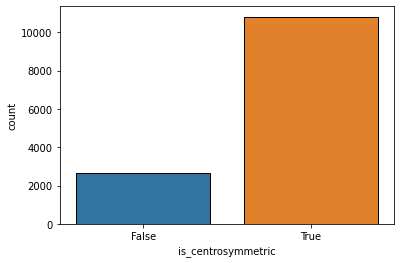

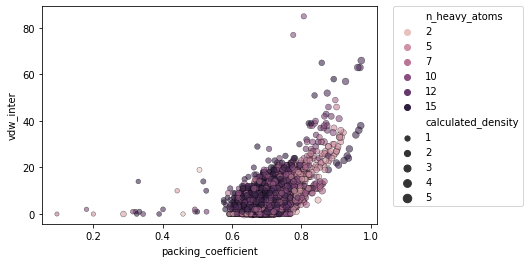

In [46]:
sns.countplot(x = 'is_centrosymmetric',data =train_crystals,edgecolor = 'black')
plt.show()
sns.scatterplot(x = 'packing_coefficient', y = 'vdw_inter', data = train_crystals, hue = 'n_heavy_atoms', size = 'calculated_density', edgecolor = 'black', alpha = 0.6)
plt.legend(bbox_to_anchor = (1.05,1), loc = 2, borderaxespad=0)
plt.show()


ML - within the train_crystals set. 

Process data to convert true / false into binary.

### Processing train_crystals dataset

In [10]:
train_crystals["is_sohncke"] = train_crystals["is_sohncke"].astype(int)
#train_crystals["spacegroup_symbol"] = train_crystals["spacegroup_symbol"].astype(int)
train_crystalsdrop = train_crystals.iloc[:, 1:]## extract out inchi / names
train_crystalsdrop = train_crystalsdrop.drop(columns = 'smiles') ## extract out smiles
#train_crystalsdrop = train_crystalsdrop.drop(columns = 'spacegroup_symbol')

train_crystalsdrop

,n_heavy_atoms,a,b,c,alpha,beta,gamma,z_value,z_prime,spacegroup_symbol,cell_volume,calculated_density,packing_coefficient,void_volume,is_centrosymmetric,is_sohncke,vdw_inter,vdw_intra,hbond_inter,hbond_intra
0,12,4.7362,17.0760,11.4150,90.0,94.432,90.0,4.0,1.0,P21/c,920.431558,1.336802,0.667769,0.0,True,0,8,6,1,0
1,15,8.9832,12.6212,9.6863,90.0,92.414,90.0,4.0,1.0,P21/n,1097.246124,1.206163,0.689272,0.0,True,0,4,16,0,0
2,14,11.1369,18.9130,4.0311,90.0,90.000,90.0,4.0,1.0,Pna21,849.079420,1.495633,0.729064,0.0,False,0,7,4,1,1
3,10,13.1840,5.9231,16.9510,90.0,90.000,90.0,8.0,1.0,Pbca,1323.706139,1.366336,0.728081,0.0,True,0,4,4,0,0
4,10,18.6000,19.9320,7.7992,90.0,90.000,90.0,16.0,1.0,Fdd2,2891.437972,1.278655,0.660441,0.0,False,0,5,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13444,15,6.0977,8.2774,15.1568,90.0,97.006,90.0,4.0,1.0,P21/c,759.298671,1.872857,0.739833,0.0,True,0,15,2,2,0
13445,12,7.3050,5.6000,24.5660,90.0,91.290,90.0,4.0,1.0,P21/c,1004.691228,1.112490,0.707207,0.0,True,0,4,18,0,0
13446,11,7.4502,10.0060,9.9600,90.0,109.960,90.0,4.0,1.0,P21/c,697.884928,1.457471,0.712136,0.0,True,0,8,4,1,0
13447,14,7.7239,10.3039,11.6239,90.0,94.128,90.0,4.0,1.0,P21/n,922.703140,1.340444,0.708705,0.0,True,0,9,5,1,0


### Number of unique spacegroup symbols

In [18]:
train_crystalsdrop.spacegroup_symbol.unique()

train_crystalsdrop['spacegroup_symbol'] = pd.factorize(train_crystalsdrop['spacegroup_symbol'])[0]
train_crystalsdrop = train_crystalsdrop.drop(columns = 'id')
train_crystalsdrop

,n_heavy_atoms,a,b,c,alpha,beta,gamma,z_value,z_prime,spacegroup_symbol,cell_volume,calculated_density,packing_coefficient,void_volume,is_centrosymmetric,is_sohncke,vdw_inter,vdw_intra,hbond_inter,hbond_intra
0,12,4.7362,17.0760,11.4150,90.0,94.432,90.0,4.0,1.0,0,920.431558,1.336802,0.667769,0.0,True,0,8,6,1,0
1,15,8.9832,12.6212,9.6863,90.0,92.414,90.0,4.0,1.0,1,1097.246124,1.206163,0.689272,0.0,True,0,4,16,0,0
2,14,11.1369,18.9130,4.0311,90.0,90.000,90.0,4.0,1.0,2,849.079420,1.495633,0.729064,0.0,False,0,7,4,1,1
3,10,13.1840,5.9231,16.9510,90.0,90.000,90.0,8.0,1.0,3,1323.706139,1.366336,0.728081,0.0,True,0,4,4,0,0
4,10,18.6000,19.9320,7.7992,90.0,90.000,90.0,16.0,1.0,4,2891.437972,1.278655,0.660441,0.0,False,0,5,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13444,15,6.0977,8.2774,15.1568,90.0,97.006,90.0,4.0,1.0,0,759.298671,1.872857,0.739833,0.0,True,0,15,2,2,0
13445,12,7.3050,5.6000,24.5660,90.0,91.290,90.0,4.0,1.0,0,1004.691228,1.112490,0.707207,0.0,True,0,4,18,0,0
13446,11,7.4502,10.0060,9.9600,90.0,109.960,90.0,4.0,1.0,0,697.884928,1.457471,0.712136,0.0,True,0,8,4,1,0
13447,14,7.7239,10.3039,11.6239,90.0,94.128,90.0,4.0,1.0,1,922.703140,1.340444,0.708705,0.0,True,0,9,5,1,0


In [21]:
dfcollist = list(train_crystalsdrop.columns.values) ## obtain the column name list
x = train_crystalsdrop.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_crystalsscale = pd.DataFrame(x_scaled)

In [187]:
y = train_crystalsdrop['spacegroup_symbol'] ### select the AlogP metric to predict 

0        0
1        1
2        2
3        3
4        4
        ..
13444    0
13445    0
13446    0
13447    1
13448    1
Name: spacegroup_symbol, Length: 13449, dtype: int64

### Baseline assessment of accuracy

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

In [59]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [61]:
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')

In [76]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

print('The f1 score is:', f1_score(y_test, rfc_predict, average='micro'))

=== Confusion Matrix ===
[[ 480   65]
 [   6 2139]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       545
         1.0       0.97      1.00      0.98      2145

    accuracy                           0.97      2690
   macro avg       0.98      0.94      0.96      2690
weighted avg       0.97      0.97      0.97      2690



=== All AUC Scores ===
[0.99006909 0.99127667 0.98345562 0.97703971 0.98341007 0.98218015
 0.98879054 0.98279161 0.98506749 0.98593578]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9850016725155072
The f1 score is: 0.9574046142362125


Rerun model with outputted optimal parameters.

In [ ]:
# rerun code with the outputted optimal parameters

#### ML - from descriptors to centrosymmetry. 

In [22]:
### XGboost on 100 most important features for centrosymmetry prediction - regression 
## Input into RF model and see what we get. 

In [23]:
train_descriptorsnona = train_descriptorsnona.drop(columns = 'identifiers')

In [24]:
dfcollist = list(train_descriptorsnona.columns.values) ## obtain the column name list
x = train_descriptorsnona.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_descriptorsnonascale  = pd.DataFrame(x_scaled)
train_descriptorsnonascale 

0         1         2    3         4         5         6    \
0      0.642493  0.624500  0.000000  0.0  0.673759  0.706468  0.777008   
1      0.791925  0.748482  0.000000  0.0  0.853264  0.742073  0.835012   
2      0.799936  0.693342  0.000000  0.0  0.770037  0.766749  0.862778   
3      0.522901  0.497235  0.000000  0.0  0.593370  0.696895  0.784176   
4      0.541885  0.528680  0.000000  0.0  0.537133  0.708054  0.763394   
...         ...       ...       ...  ...       ...       ...       ...   
13444  0.848760  0.820033  0.000000  0.0  0.858082  0.769258  0.835091   
13445  0.629433  0.506134  0.000000  0.0  0.695492  0.651797  0.727310   
13446  0.590708  0.550435  0.166667  0.0  0.611319  0.707735  0.796373   
13447  0.791925  0.679090  0.000000  0.0  0.816126  0.756020  0.850706   
13448  0.746063  0.666803  0.000000  0.0  0.784752  0.714509  0.803996   

            7         8         9         10        11        12        13   \
0      0.673759  0.812390  0.806731  0.723384  0.079041  0.888530  0.234988   
1      0.853264  0.823064  0.873524  0.856139  0.046986  0.972218  0.278182   
2      0.770037  0.795838  0.868836  0.860179  0.068421  0.956058  0.243946   
3      0.593370  0.858553  0.751886  0.683265  0.128315  0.834251  0.140423   
4      0.537133  0.777184  0.755325  0.664980  0.121808  0.829847  0.147758   
...         ...       ...       ...       ...       ...       ...       ...   
13444  0.858082  0.827711  0.888879  0.877007  0.051937  0.976448  0.285905   
13445  0.695492  0.838595  0.801112  0.813903  0.105886  0.908496  0.184064   
13446  0.611319  0.804112  0.781247  0.718361  0.106303  0.865953  0.166312   
13447  0.816126  0.843472  0.867022  0.854461  0.066967  0.954890  0.256977   
13448  0.784752  0.811047  0.851833  0.828503  0.060368  0.949518  0.267746   

            14        15        16        17        18   19   20        21   \
0      0.274153  0.000000  0.000000  0.512195  0.785714  0.0  0.0  0.384615   
1      0.259637  0.400000  0.333333  0.634146  1.000000  0.0  0.0  0.230769   
2      0.243946  0.666667  0.611111  0.512195  0.928571  0.0  0.0  0.461538   
3      0.196593  0.400000  0.333333  0.390244  0.642857  0.0  0.0  0.153846   
4      0.206861  0.333333  0.277778  0.414634  0.642857  0.0  0.0  0.307692   
...         ...       ...       ...       ...       ...  ...  ...       ...   
13444  0.266844  0.666667  0.555556  0.365854  1.000000  0.0  0.0  0.846154   
13445  0.214741  0.000000  0.000000  0.731707  0.785714  0.0  0.0  0.076923   
13446  0.211669  0.400000  0.333333  0.390244  0.714286  0.0  0.0  0.307692   
13447  0.256977  0.666667  0.611111  0.536585  0.928571  0.0  0.0  0.230769   
13448  0.267746  0.400000  0.333333  0.487805  0.928571  0.0  0.0  0.461538   

            22   23        24        25        26        27   28   29   30   \
0      0.392857  0.0  0.466667  0.250000  0.111111  0.111111  0.0  0.0  0.0   
1      0.464286  0.0  0.800000  0.250000  0.000000  0.000000  0.0  0.0  0.0   
2      0.321429  0.0  0.533333  0.416667  0.111111  0.000000  0.0  0.0  0.0   
3      0.285714  0.0  0.533333  0.000000  0.222222  0.000000  0.0  0.0  0.0   
4      0.321429  0.0  0.400000  0.250000  0.111111  0.000000  0.0  0.0  0.0   
...         ...  ...       ...       ...       ...       ...  ...  ...  ...   
13444  0.071429  0.0  0.266667  0.500000  0.555556  0.000000  0.0  0.0  0.0   
13445  0.714286  0.0  0.733333  0.000000  0.111111  0.000000  0.0  0.0  0.0   
13446  0.250000  0.0  0.466667  0.083333  0.333333  0.000000  0.0  0.0  0.0   
13447  0.357143  0.0  0.733333  0.166667  0.111111  0.000000  0.0  0.0  0.0   
13448  0.285714  0.0  0.533333  0.166667  0.333333  0.111111  0.0  0.0  0.0   

       31   32   33        34        35        36        37        38   \
0      0.0  0.0  0.0  0.288892  0.394444  0.188066  0.124486  0.104836   
1      0.0  0.0  0.0  0.349515  0.530556  0.283951  0.253086  0.235880   
2      0.0  0.0  0.0  0.425395  0.688889  0.448148  0.

In [25]:
X = train_descriptorsnonascale
y = train_crystalsdrop['spacegroup_symbol']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)
#X_train

In [28]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [29]:
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')

C:\Users\Rober\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


ValueError: multiclass format is not supported

In [32]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
#print(rfc_cv_score)
#print('\n')
print("=== Mean AUC Score ===")
#print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

print('The f1 score is:', f1_score(y_test, rfc_predict, average='macro'))

=== Confusion Matrix ===
[[612 110   3 ...   0   0   0]
 [251 135   1 ...   0   0   0]
 [ 42  10  25 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.37      0.76      0.50       805
           1       0.31      0.31      0.31       438
           2       0.64      0.29      0.40        85
           3       0.49      0.20      0.28       186
           4       0.83      0.22      0.34        23
           5       0.00      0.00      0.00         1
           6       0.62      0.35      0.44        46
           7       0.55      0.22      0.31       296
           8       0.89      0.27      0.41        30
           9       0.58      0.27      0.37       186
          10       0.00      0.00      0.00         2
          11       1.00      0.15      0.27        13
          12       0.00      0.00      0.00     

C:\Users\Rober\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rober\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Another decision tree

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
  
# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)

print('The f1 score is:', f1_score(y_test, dtree_predictions, average='macro'))

The f1 score is: 0.007480212066905616


### SVM decision

In [52]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)
  
# model accuracy for X_test  
accuracy = svm_model_linear.score(X_test, y_test)
  
# creating a confusion matrix
cm = confusion_matrix(y_test, svm_predictions)

print('The f1 score is:', f1_score(y_test, svm_predictions, average='macro'))

KeyboardInterrupt: 

In [ ]:
svmpredict = svm_model_linear.predict(test_descriptorsnonascale)
len(svmpredict)

In [ ]:
np.savetxt("bonustask_predictionssvm.csv", svmpredict)

### Naive Bayes

In [49]:
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)
  
# accuracy on X_test
accuracy = gnb.score(X_test, y_test)
print (accuracy)
  
# creating a confusion matrix
cm = confusion_matrix(y_test, gnb_predictions)

print('The f1 score is:', f1_score(y_test, gnb_predictions, average='macro'))

0.01858736059479554
The f1 score is: 0.08786092674142237


In [50]:
gnbpredict = gnb.predict(test_descriptorsnonascale)
len(gnbpredict)

3363

In [51]:
np.savetxt("bonustask_predictionsBayes.csv", gnbpredict)

### Simple Neural Net

In [53]:
from sklearn.neural_network import MLPClassifier

In [54]:
snn_classifier = MLPClassifier()
snn_classifier.fit(X_train, y_train)
snn_predictions = snn_classifier.predict(X_test)

C:\Users\Rober\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [66]:
len(snn_predictions)
(y_test)

228       7
11431     0
1573      0
6156     25
13312     1
         ..
856       9
11447     7
1451      9
13350     0
5312      7
Name: spacegroup_symbol, Length: 2690, dtype: int64

In [69]:
snn_predictions

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [58]:
mean_absolute_error(y_test, snn_predictions)

8.824907063197026

### Alternative Neural Net

In [71]:
dnn_classifier = MLPClassifier(hidden_layer_sizes = [100]*5)
dnn_classifier.fit(X_train, y_train)
dnn_predictions = dnn_classifier.predict(X_test)

C:\Users\Rober\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [76]:
mean_absolute_error(y_test, dnn_predictions, multioutput='raw_values')


array([8.93643123])

In [74]:
y_test

228       7
11431     0
1573      0
6156     25
13312     1
         ..
856       9
11447     7
1451      9
13350     0
5312      7
Name: spacegroup_symbol, Length: 2690, dtype: int64

In [77]:
print('The f1 score is:', f1_score(y_test, dnn_predictions, average='macro'))

The f1 score is: 0.16151486482844277


In [79]:
dnn_classifier = MLPClassifier(hidden_layer_sizes = [100]*5)
dnn_classifier.fit(X,y)

C:\Users\Rober\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=[100, 100, 100, 100, 100])

In [80]:
dnnpredict = dnn_classifier.predict(test_descriptorsnonascale)
len(dnnpredict)

3363

In [81]:
dnnpredict

array([ 1, 25,  0, ...,  1,  0,  7], dtype=int64)

In [83]:
np.savetxt("bonustask_predictionsDNN.csv", dnnpredict)

### Perform on the test_descriptors dataset

In [33]:
test_descriptors = pd.read_csv("test_descriptors.csv")

In [193]:
len(test_descriptors)

3363

In [34]:
test_descriptors = test_descriptors.dropna(axis=1, how="any", thresh=None, subset=None, inplace=False)
test_descriptors

identifiers  Unnamed: 0                      name        ABC      ABCGG  \
0       WOKPER02       62533  Optimised_Molecules_V...  11.549067  10.258331   
1         QAFVAU       52294  Optimised_Molecules_V...  11.629947  10.600629   
2         YIRLIV       64221  Optimised_Molecules_V...  11.492048  10.321229   
3         FUWPIW       34287  Optimised_Molecules_V...   9.658457   9.148596   
4         JODTAX       40419  Optimised_Molecules_V...  10.894331   9.805274   
...          ...         ...                       ...        ...        ...   
3358      TIYDEM       57993  Optimised_Molecules_V...   8.299214   9.157523   
3359      IZUTIH       40009  Optimised_Molecules_V...  12.037394  10.307385   
3360      NIPQUA       48110  Optimised_Molecules_V...   4.352030   4.798324   
3361      NUQDIO       48637  Optimised_Molecules_V...  10.784941   9.263360   
3362    PUZHIB02       51929  Optimised_Molecules_V...   8.898979   8.883053   

      nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A     SpAD_A   SpMAD_A  \
0         0      0  18.481449  2.448488  4.896977  18.481449  1.232097   
1         1      0  18.188997  2.452357  4.790463  18.188997  1.212600   
2         0      2  19.145390  2.298181  4.575893  19.145390  1.276359   
3         0      0  14.911280  2.342923  4.685846  14.911280  1.147022   
4         0      0  18.338436  2.285262  4.570525  18.338436  1.222562   
...     ...    ...        ...       ...       ...        ...       ...   
3358      0      2  13.267203  2.389655  4.779311  13.267203  1.105600   
3359      0      0  19.829524  2.512598  4.931109  19.829524  1.321968   
3360      0      0   7.878462  1.969616  3.939231   7.878462  1.125495   
3361      0      0  17.809610  2.334414  4.668828  17.809610  1.272115   
3362      0      0  14.601126  2.414214  4.828427  14.601126  1.216761   

       LogEE_A     VE1_A     VE2_A     VE3_A       VR1_A     VR2_A     VR3_A  \
0     3.639384  3.541827  0.236122  1.670108   68.166487  4.544432  4.627418   
1     3.641152  3.444305  0.229620  1.642187   80.218107  5.347874  4.790214   
2     3.629138  3.662240  0.244149  1.703540   66.800756  4.453384  4.607180   
3     3.457630  3.254819  0.250371  1.442501   53.605048  4.123465  4.244008   
4     3.585915  3.345029  0.223002  1.612940  111.593207  7.439547  5.120325   
...        ...       ...       ...       ...         ...       ...       ...   
3358  3.340129  3.036021  0.253002  1.292869   40.820224  3.401685  3.891499   
3359  3.680849  3.567730  0.237849  1.677395   75.052738  5.003516  4.723656   
3360  2.752840  2.458387  0.351198  0.542830   16.738732  2.391247  2.461050   
3361  3.564444  3.494701  0.249621  1.587720   62.320194  4.451442  4.468758   
3362  3.391683  3.200413  0.266701  1.345601   40.625057  3.385421  3.886707   

      nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  nBridgehead  nHetero  \
0            10         11     23          15       0            0        4   
1             9         10     22          15       0            0        5   
2             6          6     24          15       0            0        5   
3             6          6     19          13       0            0        5   
4             6          6     28          15       0            0        4   
...         ...        ...    ...         ...     ...          ...      ...   
3358          0          0     14          12       0            0       10   
3359         10         11     20          15       0            0        5   
3360          0          0     16           7       0            0        3   
3361         12         12     20          14       0            0        4   
3362          6          6     21          12       0            0        3   

      nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX      ATS0dv  \
0      8   0  11   0   4   0   0   0    0    0   0   0  266.000000   
1      7   0  10   1   2   0   0   0    2    0   0   2  205.209877   
2      9   0  10   2   2   0   0   

In [35]:
### clean the test_descriptors dataset
test_descriptors = test_descriptors.drop(columns = 'SMILES')
test_descriptors = test_descriptors.drop(columns = 'InchiKey')
test_descriptors = test_descriptors.drop(columns = 'name')
test_descriptors = test_descriptors.drop(columns = 'Unnamed: 0')


In [36]:
common_cols = [col for col in set(test_descriptors.columns).intersection(train_descriptorsnona.columns)]
symmetric = test_descriptors[common_cols]
symmetric= symmetric[train_descriptorsnona.columns]
symmetric

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     11.549067  10.258331      0      0  18.481449  2.448488  4.896977   
1     11.629947  10.600629      1      0  18.188997  2.452357  4.790463   
2     11.492048  10.321229      0      2  19.145390  2.298181  4.575893   
3      9.658457   9.148596      0      0  14.911280  2.342923  4.685846   
4     10.894331   9.805274      0      0  18.338436  2.285262  4.570525   
...         ...        ...    ...    ...        ...       ...       ...   
3358   8.299214   9.157523      0      2  13.267203  2.389655  4.779311   
3359  12.037394  10.307385      0      0  19.829524  2.512598  4.931109   
3360   4.352030   4.798324      0      0   7.878462  1.969616  3.939231   
3361  10.784941   9.263360      0      0  17.809610  2.334414  4.668828   
3362   8.898979   8.883053      0      0  14.601126  2.414214  4.828427   

         SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A     VE3_A       VR1_A  \
0     18.481449  1.232097  3.639384  3.541827  0.236122  1.670108   68.166487   
1     18.188997  1.212600  3.641152  3.444305  0.229620  1.642187   80.218107   
2     19.145390  1.276359  3.629138  3.662240  0.244149  1.703540   66.800756   
3     14.911280  1.147022  3.457630  3.254819  0.250371  1.442501   53.605048   
4     18.338436  1.222562  3.585915  3.345029  0.223002  1.612940  111.593207   
...         ...       ...       ...       ...       ...       ...         ...   
3358  13.267203  1.105600  3.340129  3.036021  0.253002  1.292869   40.820224   
3359  19.829524  1.321968  3.680849  3.567730  0.237849  1.677395   75.052738   
3360   7.878462  1.125495  2.752840  2.458387  0.351198  0.542830   16.738732   
3361  17.809610  1.272115  3.564444  3.494701  0.249621  1.587720   62.320194   
3362  14.601126  1.216761  3.391683  3.200413  0.266701  1.345601   40.625057   

         VR2_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  nBridgehead  \
0     4.544432         10         11     23          15       0            0   
1     5.347874          9         10     22          15       0            0   
2     4.453384          6          6     24          15       0            0   
3     4.123465          6          6     19          13       0            0   
4     7.439547          6          6     28          15       0            0   
...        ...        ...        ...    ...         ...     ...          ...   
3358  3.401685          0          0     14          12       0            0   
3359  5.003516         10         11     20          15       0            0   
3360  2.391247          0          0     16           7       0            0   
3361  4.451442         12         12     20          14       0            0   
3362  3.385421          6          6     21          12       0            0   

      nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX      ATS0dv  \
0           4   8   0  11   0   4   0   0   0    0    0   0   0  266.000000   
1           5   7   0  10   1   2   0   0   0    2    0   0   2  205.209877   
2           5   9   0  10   2   2   0   0   0    0    1   0   1  221.067215   
3           5   6   0   8   1   1   0   0   0    3    0   0   3  152.814815   
4           4  13   0  11   1   1   0   0   0    2    0   0   2  157.209877   
...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..         ...   
3358       10   2   0   2   4   4   0   0   0    0    2   0   2  268.134431   
3359        5   5   0  10   1   2   2   0   0    0    0   0   0  226.888889   
3360        3   9   0   4   1   2   0   0   0    0    0   0   0  108.000000   
3361        4   6   0  10   2   0   0   0   0    2    0   0   2  169.209877   
3362        3   9   0   9   0   0   0   0   0    0    3   0   3   99.201646   

          ATS1dv      ATS2dv      ATS3dv      ATS4dv      ATS5dv      ATS6dv  \
0     251.000000  374.000000  416.000000  385.000000  148.000000   72.000000   
1     202.222222  273.111111  226.555556  200.604938  167.555556  10

In [37]:
dfcollist = list(symmetric.columns.values) ## obtain the column name list
x = symmetric.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
test_descriptorsnonascale  = pd.DataFrame(x_scaled)
test_descriptorsnonascale 

0         1     2    3         4         5         6         7    \
0     0.844943  0.837899  0.00  0.0  0.848841  0.724244  0.813403  0.848841   
1     0.850860  0.865858  0.25  0.0  0.833779  0.726179  0.783496  0.833779   
2     0.840771  0.843037  0.00  0.4  0.883036  0.649090  0.723250  0.883036   
3     0.706623  0.747256  0.00  0.0  0.664968  0.671462  0.754122  0.664968   
4     0.797041  0.800893  0.00  0.0  0.841476  0.642631  0.721743  0.841476   
...        ...       ...   ...  ...       ...       ...       ...       ...   
3358  0.607180  0.747985  0.00  0.4  0.580293  0.694828  0.780365  0.580293   
3359  0.880669  0.841906  0.00  0.0  0.918271  0.756299  0.822986  0.918271   
3360  0.318399  0.391926  0.00  0.0  0.302757  0.484808  0.544490  0.302757   
3361  0.789038  0.756630  0.00  0.0  0.814240  0.667207  0.749344  0.814240   
3362  0.651059  0.725567  0.00  0.0  0.648994  0.707107  0.794156  0.648994   

           8         9         10        11        12        13        14   \
0     0.650774  0.864470  0.895111  0.071995  0.977333  0.173482  0.153253   
1     0.621410  0.865154  0.854082  0.059185  0.968029  0.204803  0.185340   
2     0.717437  0.860501  0.945770  0.087812  0.988473  0.169932  0.149617   
3     0.522644  0.794068  0.774364  0.100070  0.901489  0.135638  0.136441   
4     0.636414  0.843758  0.812316  0.046144  0.958283  0.286343  0.268876   
...        ...       ...       ...       ...       ...       ...       ...   
3358  0.460260  0.748554  0.682313  0.105254  0.851628  0.102412  0.107615   
3359  0.786128  0.880531  0.906009  0.075397  0.979761  0.191378  0.171588   
3360  0.490222  0.521070  0.439296  0.298735  0.601698  0.039827  0.067260   
3361  0.711045  0.835442  0.875285  0.098594  0.949879  0.158288  0.149539   
3362  0.627676  0.768524  0.751474  0.132247  0.869200  0.101905  0.106965   

           15        16     17        18   19   20        21        22   23   \
0     0.666667  0.611111  0.525  1.000000  0.0  0.0  0.307692  0.285714  0.0   
1     0.600000  0.555556  0.500  1.000000  0.0  0.0  0.384615  0.250000  0.0   
2     0.400000  0.333333  0.550  1.000000  0.0  0.0  0.384615  0.321429  0.0   
3     0.400000  0.333333  0.425  0.846154  0.0  0.0  0.384615  0.214286  0.0   
4     0.400000  0.333333  0.650  1.000000  0.0  0.0  0.307692  0.464286  0.0   
...        ...       ...    ...       ...  ...  ...       ...       ...  ...   
3358  0.000000  0.000000  0.300  0.769231  0.0  0.0  0.769231  0.071429  0.0   
3359  0.666667  0.611111  0.450  1.000000  0.0  0.0  0.384615  0.178571  0.0   
3360  0.000000  0.000000  0.350  0.384615  0.0  0.0  0.230769  0.321429  0.0   
3361  0.800000  0.666667  0.450  0.923077  0.0  0.0  0.307692  0.214286  0.0   
3362  0.400000  0.333333  0.475  0.769231  0.0  0.0  0.230769  0.321429  0.0   

           24        25     26    27   28   29   30        31   32   33   \
0     0.733333  0.000000  0.500  0.00  0.0  0.0  0.0  0.000000  0.0  0.0   
1     0.666667  0.083333  0.250  0.00  0.0  0.0  0.2  0.000000  0.0  0.2   
2     0.666667  0.166667  0.250  0.00  0.0  0.0  0.0  0.166667  0.0  0.1   
3     0.533333  0.083333  0.125  0.00  0.0  0.0  0.3  0.000000  0.0  0.3   
4     0.733333  0.083333  0.125  0.00  0.0  0.0  0.2  0.000000  0.0  0.2   
...        ...       ...    ...   ...  ...  ...  ...       ...  ...  ...   
3358  0.133333  0.333333  0.500  0.00  0.0  0.0  0.0  0.333333  0.0  0.2   
3359  0.666667  0.083333  0.250  0.25  0.0  0.0  0.0  0.000000  0.0  0.0   
3360  0.266667  0.083333  0.250  0.00  0.0  0.0  0.0  0.000000  0.0  0.0   
3361  0.666667  0.166667  0.000  0.00  0.0  0.0  0.2  0.000000  0.0  0.2   
3362  0.600000  0.000000  0.000  0.00  0.0  0.0  0.0  0.500000  0.0  0.3   

           34        35        36        37        38        39        40   \
0     0.606821  0.729175  0.581716  0.613569  0.383085  0.295409  0.142012   
1     0.467859  0.587129  0.424794  0.334153  0.199607  0.334442  0.209511   
2     0.504108  0

## MAKE PREDICTION 

In [38]:
rfc_predict = rfc.predict(test_descriptorsnonascale)
len(rfc_predict)

3363

In [39]:
np.savetxt("bonustask_predictions.csv", rfc_predict)

In [40]:
rfc_predict

array([1, 1, 7, ..., 0, 1, 7], dtype=int64)

### Hyper parameter tuning

In [215]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# number of features at every split
max_features = ['auto','sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 5)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

C:\Users\Rober\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits


KeyboardInterrupt: 